<a href="https://colab.research.google.com/github/hanmrf/MachineLearning/blob/main/Grape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data

In [ ]:
# Impor library yang dibutuhkan
from IPython import get_ipython
from IPython.display import display
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from google.colab import files
import numpy as np
from tensorflow.keras.preprocessing import image
from PIL import Image, ImageDraw, ImageOps # Impor Image dan ImageDraw dari PIL

In [ ]:
!chmod 600 /content/kaggle.json

In [ ]:
! KAGGLE_CONFIG_DIR=/content/ kaggle datasets download muhammadraihanf12/agricurify-grape

Dataset URL: https://www.kaggle.com/datasets/muhammadraihanf12/agricurify-grape
License(s): unknown
 99% 671M/675M [00:06<00:00, 135MB/s]
100% 675M/675M [00:06<00:00, 104MB/s]


In [ ]:
import zipfile

# Lokasi file ZIP
zip_file_path = "/content/agricurify-grape.zip"
extract_to_path = "/content/"

# Mengekstrak file ZIP
if os.path.exists(zip_file_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to_path)
        print("File berhasil diekstrak ke direktori:", extract_to_path)
else:
    print("File ZIP tidak ditemukan di lokasi:", zip_file_path)

File berhasil diekstrak ke direktori: /content/


In [ ]:

# Daftar direktori dataset
dataset_dirs = [
    "/content/Grape___Black_rot",
    "/content/Grape___Esca_(Black_Measles)",
    "/content/Grape___Leaf_blight_(Isariopsis_Leaf_Spot)",
    "/content/Grape___healthy",
    "/content/Non___Grape"
]

# Direktori tujuan untuk dataset gabungan
merged_dataset_dir = "/content/Merged_Grape"

# Buat direktori tujuan jika belum ada
os.makedirs(merged_dataset_dir, exist_ok=True)

# Salin gambar dari setiap direktori dataset ke direktori tujuan, pertahankan struktur kelas
for dataset_dir in dataset_dirs:
    # Dapatkan nama kelas dari nama direktori
    class_name = os.path.basename(dataset_dir)

    # Buat sub-direktori kelas di direktori tujuan jika belum ada
    target_class_dir = os.path.join(merged_dataset_dir, class_name)
    os.makedirs(target_class_dir, exist_ok=True)

    # Salin gambar dari direktori dataset ke sub-direktori kelas di direktori tujuan
    for filename in os.listdir(dataset_dir):
        src_path = os.path.join(dataset_dir, filename)
        dst_path = os.path.join(target_class_dir, filename)
        shutil.copy(src_path, dst_path)

print("Dataset telah digabungkan ke:", merged_dataset_dir)

Dataset telah digabungkan ke: /content/Merged_Grape


In [ ]:
grape_data = "/content/Merged_Grape"
grape_classes = os.listdir(grape_data)

print("grape_classes:")
for classes in grape_classes:
    if os.path.isdir(os.path.join(grape_data, classes)):
        print(classes)

grape_classes:
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
Non___Grape
Grape___Esca_(Black_Measles)
Grape___Black_rot
Grape___healthy



Class Name: Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
Total Images: 5351
Resolution of First Image: (256, 256, 3)


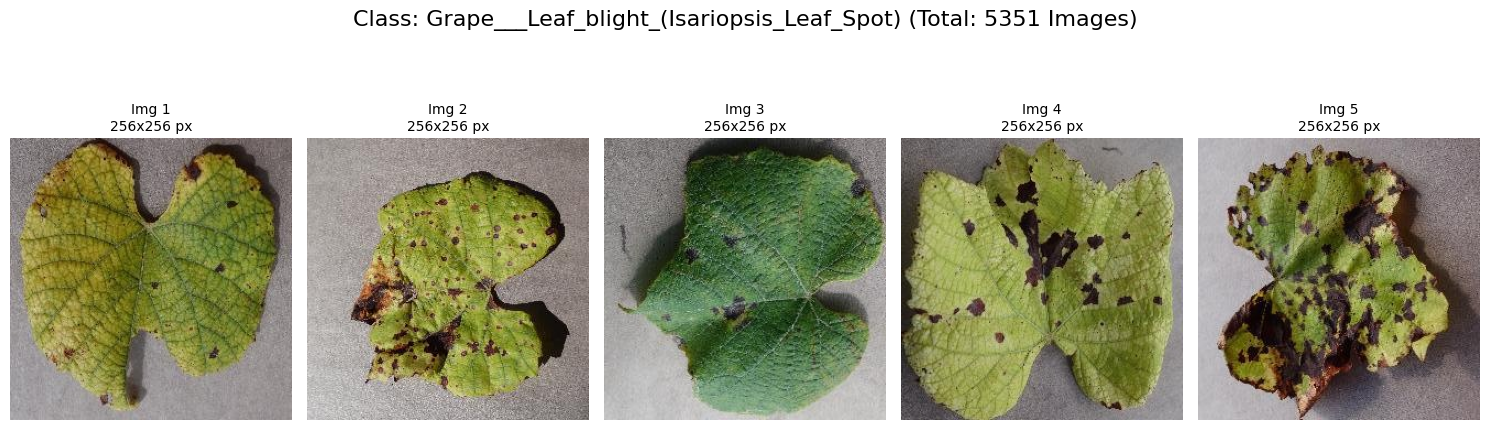


Class Name: Non___Grape
Total Images: 5047
Resolution of First Image: (255, 222, 3)


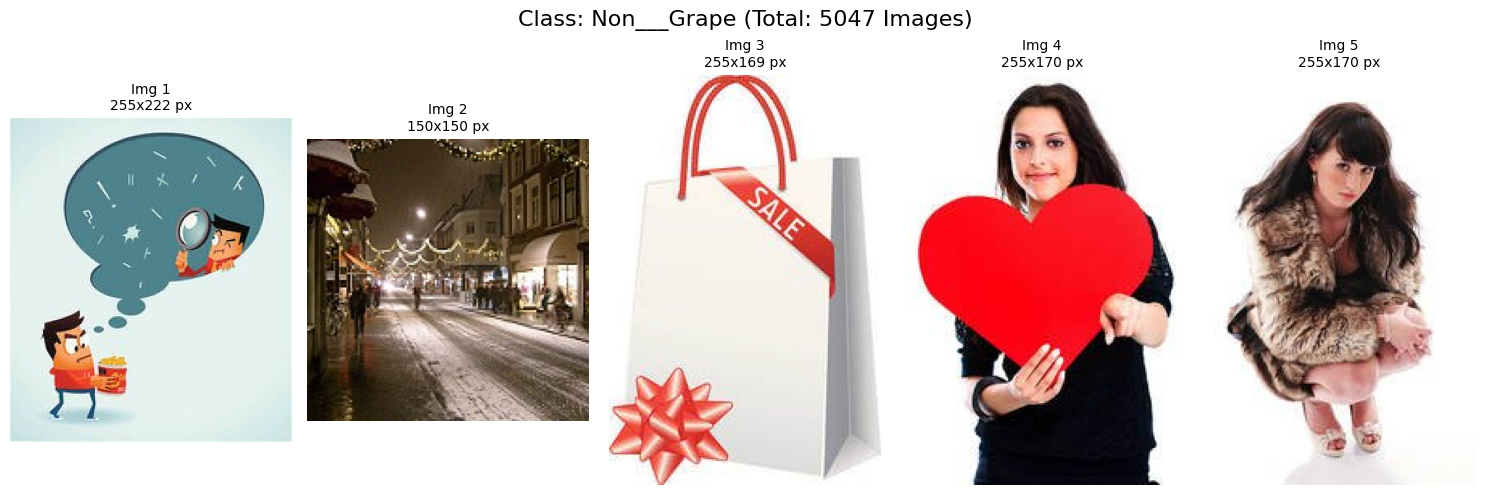


Class Name: Grape___Esca_(Black_Measles)
Total Images: 5185
Resolution of First Image: (256, 256, 3)


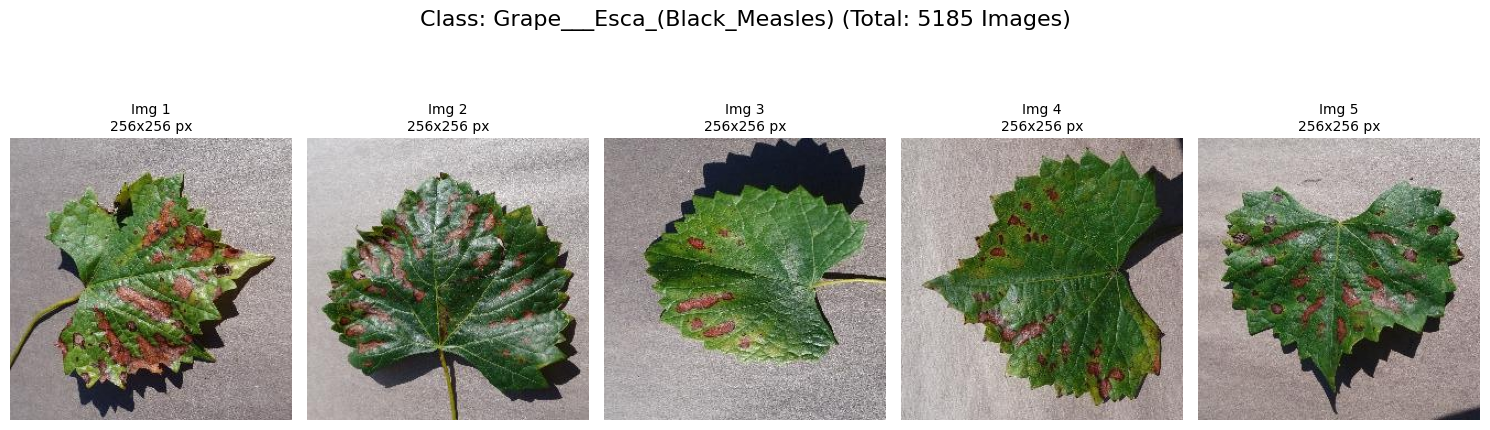


Class Name: Grape___Black_rot
Total Images: 5445
Resolution of First Image: (256, 256, 3)


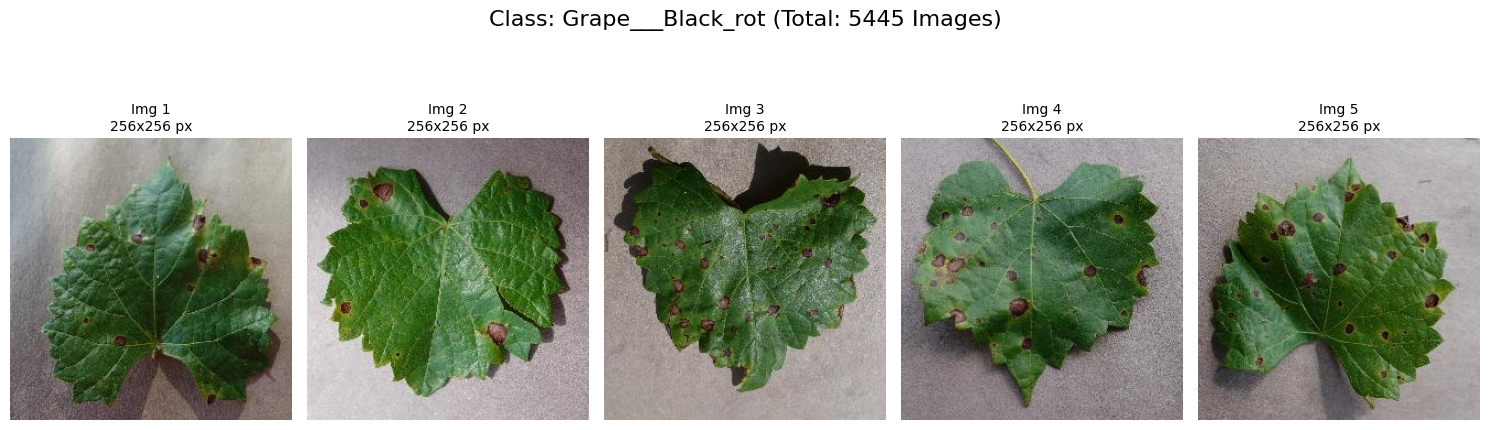


Class Name: Grape___healthy
Total Images: 5111
Resolution of First Image: (256, 256, 3)


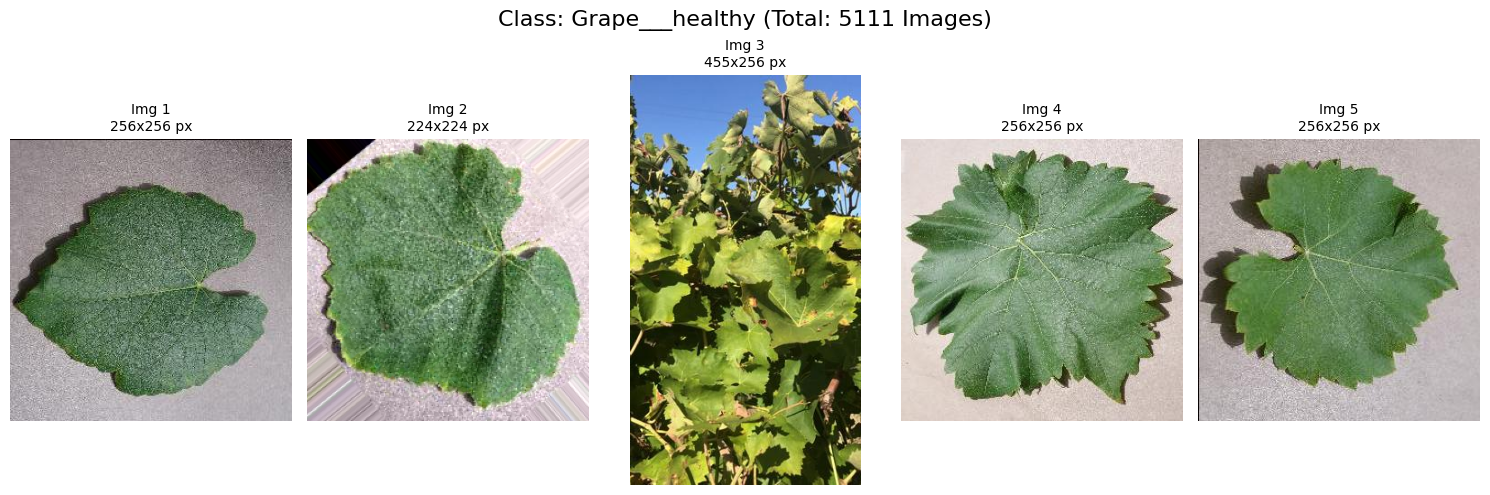

In [ ]:
for item in grape_classes:
    print("\nClass Name:", item)
    class_dir = os.path.join(grape_data, item)
    class_images = os.listdir(class_dir)

    # Total images in each class
    num_images = len(class_images)
    print("Total Images:", num_images)

    # Resolution/size of the first image in the class
    img_path = os.path.join(class_dir, class_images[0])
    img = mpimg.imread(img_path)
    image_shape = img.shape
    print("Resolution of First Image:", image_shape)

    # Displaying some images with descriptive labels
    plt.figure(figsize=(15, 5))
    plt.suptitle(f"Class: {item} (Total: {num_images} Images)", fontsize=16)

    for i, img_file in enumerate(class_images[:5]):  # Display up to 5 images
        img_path = os.path.join(class_dir, img_file)
        img = mpimg.imread(img_path)

        # Add a subplot for each image
        sp = plt.subplot(1, 5, i + 1)
        plt.axis('off')
        plt.imshow(img)

        # Add descriptive title to each image
        plt.title(f"Img {i+1}\n{img.shape[0]}x{img.shape[1]} px", fontsize=10)

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Adjust to fit the suptitle
    plt.show()

# Preprocesing Dataset

In [ ]:
# New Directory for Balanced and Finalizing Dataset
Final_data_dir = "/content/Final_data"

# Number of Images to Be Selected from Each Class
num_images_per_class = min(len(os.listdir(os.path.join(grape_data, "Grape___Esca_(Black_Measles)"))),
                           len(os.listdir(os.path.join(grape_data, "Grape___Black_rot"))),
                           len(os.listdir(os.path.join(grape_data, "Grape___Leaf_blight_(Isariopsis_Leaf_Spot)"))),
                           len(os.listdir(os.path.join(grape_data, "Grape___healthy"))),
                           len(os.listdir(os.path.join(grape_data, "Non___Grape"))))

# Create New Directory in Final_data_dir
for class_name in grape_classes:
    os.makedirs(os.path.join(Final_data_dir, class_name), exist_ok=True)

# Select Some Images from Each Class and Copy to Final_data_dir
for class_name in grape_classes:
    source_dir = os.path.join(grape_data, class_name)
    destination_dir = os.path.join(Final_data_dir, class_name)

    # Get a list of image files in the source directory
    image_files = os.listdir(source_dir)

    # Select a subset of images (up to num_images_per_class)
    selected_images = image_files[:num_images_per_class]

    # Copy the selected images to the destination directory
    for image_file in selected_images:
        shutil.copy(os.path.join(source_dir, image_file), destination_dir)

print(f"Final_data dataset created in: {Final_data_dir}")

Final_data dataset created in: /content/Final_data


Preview Final Dataset:

Kelas: Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
Total Gambar: 5047


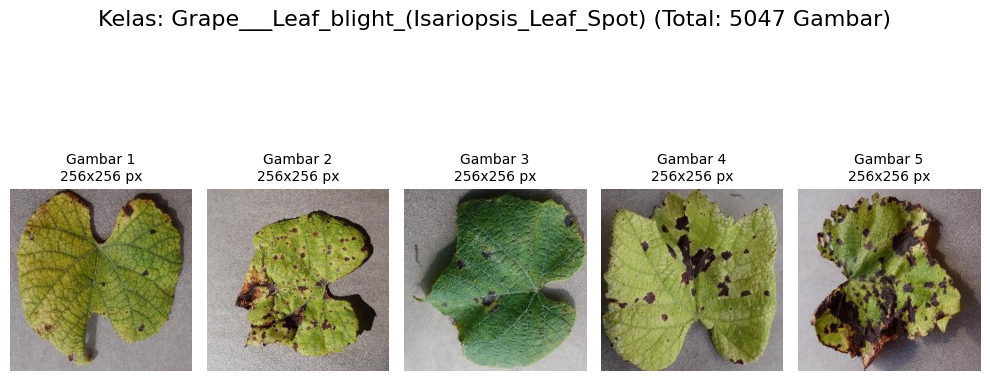


Kelas: Non___Grape
Total Gambar: 5047


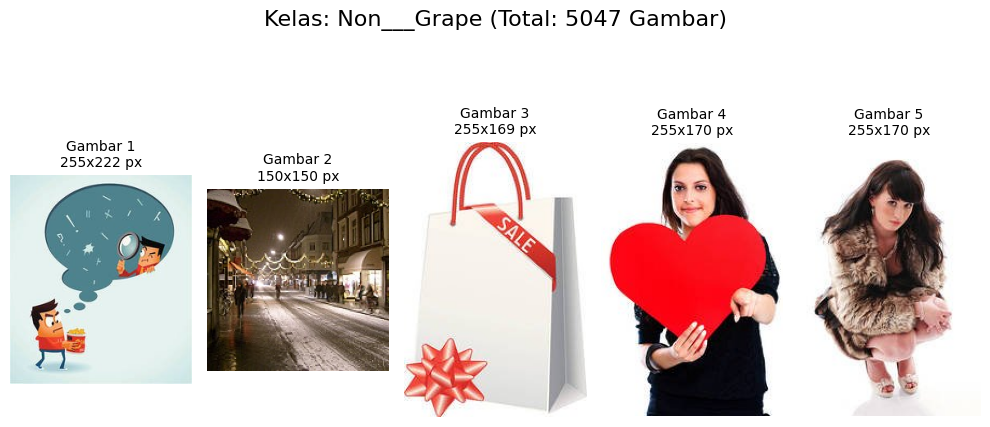


Kelas: Grape___Esca_(Black_Measles)
Total Gambar: 5047


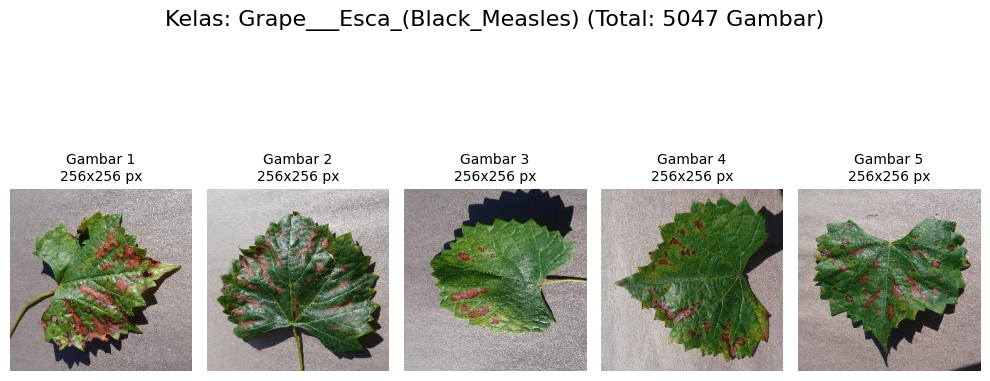


Kelas: Grape___Black_rot
Total Gambar: 5047


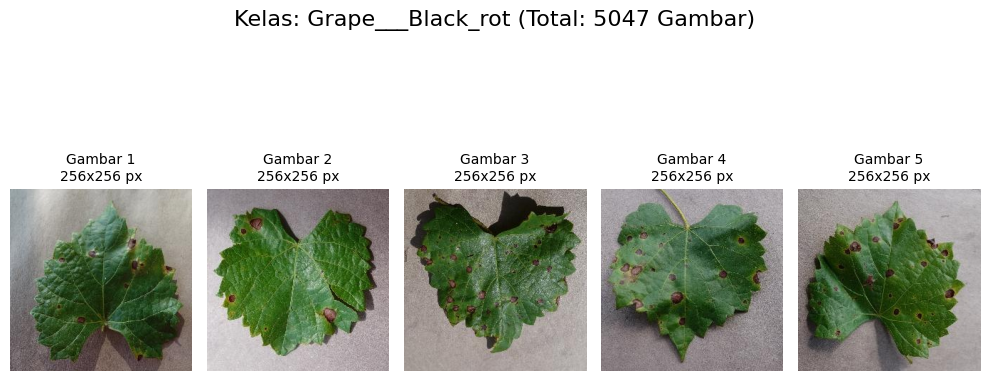


Kelas: Grape___healthy
Total Gambar: 5047


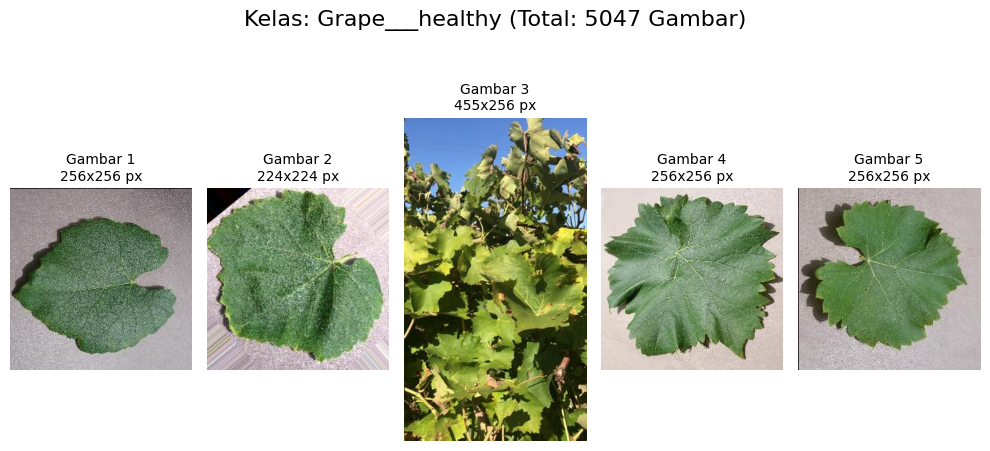

In [ ]:
# Preview Gambar dari Final dataset
print("Preview Final Dataset:")

for class_name in grape_classes:
    print(f"\nKelas: {class_name}")

    # Direktori kelas
    class_dir = os.path.join(Final_data_dir, class_name)

    # Daftar gambar dalam kelas
    class_images = os.listdir(class_dir)

    # Total gambar dalam kelas
    num_images = len(class_images)
    print(f"Total Gambar: {num_images}")

    # Menampilkan beberapa gambar dari kelas
    plt.figure(figsize=(10, 5))
    plt.suptitle(f"Kelas: {class_name} (Total: {num_images} Gambar)", fontsize=16)

    for i, image_file in enumerate(class_images[:5]):  # Menampilkan hingga 5 gambar
        image_path = os.path.join(class_dir, image_file)
        image = mpimg.imread(image_path)

        # Menambahkan subplot untuk setiap gambar
        plt.subplot(1, 5, i + 1)
        plt.axis('off')
        plt.imshow(image)

        # Menambahkan judul deskriptif ke setiap gambar
        plt.title(f"Gambar {i + 1}\n{image.shape[0]}x{image.shape[1]} px", fontsize=10)

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Menyesuaikan untuk judul utama
    plt.show()

# SPLIT MODEL

In [ ]:
import random

# Dataset directory and class names
dataset_dir = "/content/Final_data"
classes = [
    "Grape___Black_rot",
    "Grape___Esca_(Black_Measles)",
    "Grape___Leaf_blight_(Isariopsis_Leaf_Spot)",
    "Grape___healthy",
    "Non___Grape"
]

# Ratios for splitting data
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Process each class
for class_name in classes:
    # Define class directory and fetch files
    class_dir = os.path.join(dataset_dir, class_name)
    files = os.listdir(class_dir)
    random.shuffle(files)

    # Calculate split sizes
    num_files = len(files)

    # Ensure there are enough files for each split
    if num_files < 3:
        print(f"Not enough files in {class_name} to split into train, val, and test sets.")
        continue

    num_train = max(1, int(num_files * train_ratio))
    num_val = max(1, int(num_files * val_ratio))
    num_test = num_files - num_train - num_val

    # Adjust if necessary to ensure all splits are non-empty
    if num_test < 1:
        num_test = 1
        num_val = num_files - num_train - num_test

    if num_val < 1:
        num_val = 1
        num_test = num_files - num_train - num_val

    # Split files into train, validation, and test sets
    train_files = files[:num_train]
    val_files = files[num_train:num_train + num_val]
    test_files = files[num_train + num_val:]

    # Move files to respective folders
    for folder_name, file_list in [("train", train_files), ("val", val_files), ("test", test_files)]:
        folder_path = os.path.join(dataset_dir, folder_name, class_name)
        os.makedirs(folder_path, exist_ok=True)

        for file in file_list:
            src = os.path.join(class_dir, file)
            dst = os.path.join(folder_path, file)
            shutil.move(src, dst)

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directory paths
train_dir = '/content/Final_data/train'
val_dir = '/content/Final_data/val'
test_dir = '/content/Final_data/test'

# Image size yang sesuai dengan MobileNetV2 input
img_size = 224
batch_size = 32

# Data Augmentation untuk data latih
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

# Menggunakan flow_from_directory untuk membaca gambar dari direktori
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical')



Found 20184 images belonging to 5 classes.
Found 2520 images belonging to 5 classes.
Found 2530 images belonging to 5 classes.


# MODELLING


In [ ]:
# Inisialisasi model MobileNetV2 yang pre-trained
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze layers MobileNetV2
base_model.trainable = False

# Membuat model baru dengan tambahan lapisan kustom
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')  # 5 kelas untuk kerusakan buah anggur
])

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,916,421 (11.13 MB)

 Trainable params: 658,437 (2.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    verbose=2
)

# Evaluasi model pada data val
val_loss, val_acc = model.evaluate(val_generator)
print(f'Validation accuracy: {val_acc * 100:.2f}%')


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


631/631 - 284s - 450ms/step - accuracy: 0.9401 - loss: 0.1624 - val_accuracy: 0.9671 - val_loss: 0.0798
Epoch 2/10
631/631 - 303s - 481ms/step - accuracy: 0.9659 - loss: 0.0910 - val_accuracy: 0.9837 - val_loss: 0.0418
Epoch 3/10
631/631 - 259s - 411ms/step - accuracy: 0.9708 - loss: 0.0830 - val_accuracy: 0.9829 - val_loss: 0.0426
Epoch 4/10
631/631 - 262s - 414ms/step - accuracy: 0.9723 - loss: 0.0771 - val_accuracy: 0.9833 - val_loss: 0.0399
Epoch 5/10
631/631 - 257s - 407ms/step - accuracy: 0.9747 - loss: 0.0669 - val_accuracy: 0.9853 - val_loss: 0.0387
Epoch 6/10
631/631 - 266s - 421ms/step - accuracy: 0.9760 - loss: 0.0677 - val_accuracy: 0.9837 - val_loss: 0.0422
Epoch 7/10
631/631 - 264s - 418ms/step - accuracy: 0.9774 - loss: 0.0612 - val_accuracy: 0.9901 - val_loss: 0.0333
Epoch 8/10
631/631 - 260s - 412ms/step - accuracy: 0.9771 - loss: 0.0644 - val_accuracy: 0.9857 - val_loss: 0.0399
Epoch 9/10
631/631 - 260s - 412ms/step - accuracy: 0.9791 - loss: 0.0567 - val_accuracy: 0.

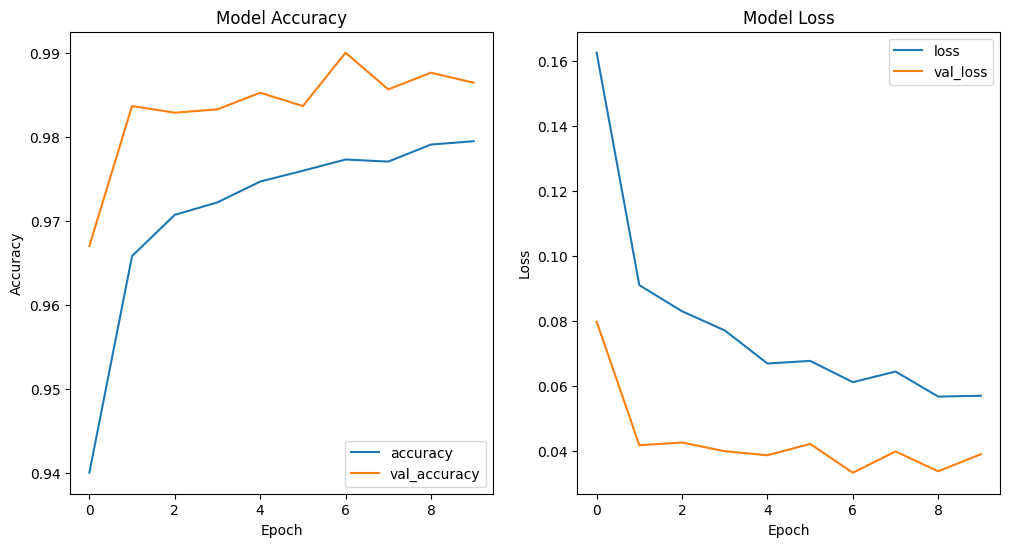

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Plotting accuracy and loss
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()



Found 2530 images belonging to 5 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step


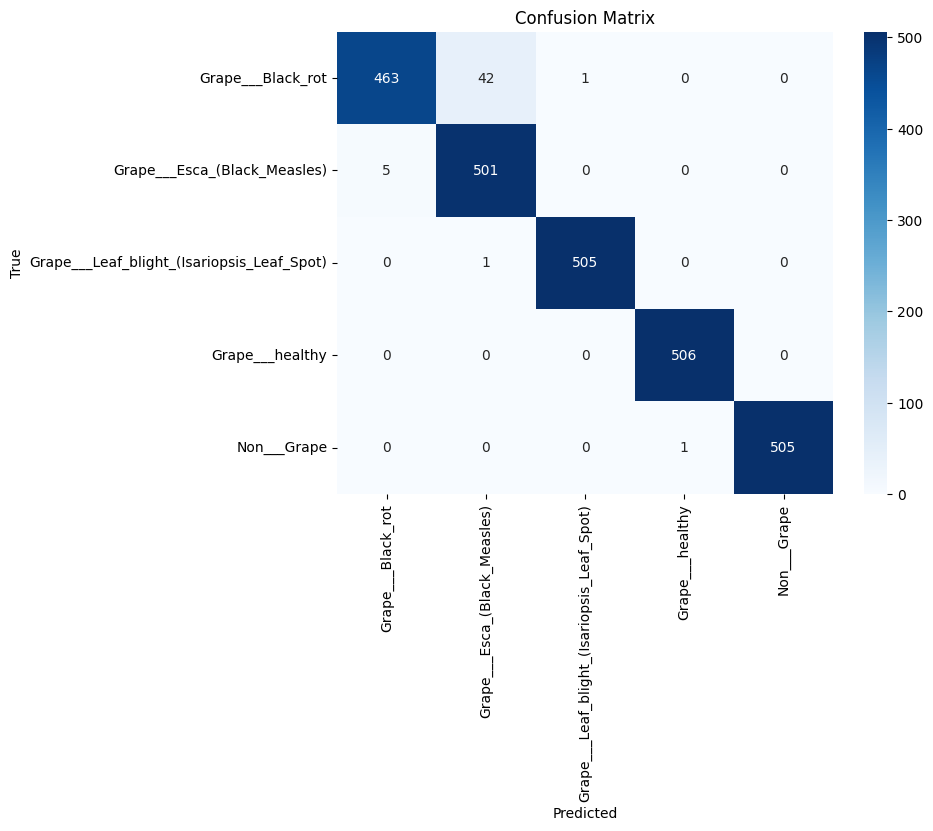

In [ ]:
# Confusion Matrix (untuk data testing)
test_generator = val_datagen.flow_from_directory(test_dir, target_size=(img_size, img_size), batch_size=batch_size, class_mode='categorical', shuffle=False)

# Prediksi dengan model yang telah dilatih
test_preds = model.predict(test_generator, verbose=1)
test_preds = np.argmax(test_preds, axis=1)

# Confusion matrix
cm = confusion_matrix(test_generator.classes, test_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Fine Tuning

In [ ]:
# Unfreeze beberapa layer terakhir dari base model
for layer in base_model.layers[-20:]:  # Ubah angka -20 untuk mengatur jumlah layer yang di-unfreeze
    layer.trainable = True

# Compile ulang model dengan learning rate yang lebih rendah
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Learning rate yang lebih rendah
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Lanjutkan training model dengan data yang sama
history_fine_tuning = model.fit(
    train_generator,
    epochs=10,  # Sesuaikan jumlah epochs
    validation_data=val_generator,
    verbose=2
)

Epoch 1/10
631/631 - 289s - 457ms/step - accuracy: 0.8548 - loss: 1.7233 - val_accuracy: 0.9885 - val_loss: 0.0294
Epoch 2/10
631/631 - 264s - 418ms/step - accuracy: 0.9628 - loss: 0.1073 - val_accuracy: 0.9905 - val_loss: 0.0279
Epoch 3/10
631/631 - 325s - 514ms/step - accuracy: 0.9741 - loss: 0.0762 - val_accuracy: 0.9905 - val_loss: 0.0279
Epoch 4/10
631/631 - 317s - 502ms/step - accuracy: 0.9779 - loss: 0.0628 - val_accuracy: 0.9929 - val_loss: 0.0231
Epoch 5/10
631/631 - 267s - 422ms/step - accuracy: 0.9799 - loss: 0.0562 - val_accuracy: 0.9921 - val_loss: 0.0216
Epoch 6/10
631/631 - 260s - 412ms/step - accuracy: 0.9838 - loss: 0.0453 - val_accuracy: 0.9940 - val_loss: 0.0188
Epoch 7/10
631/631 - 259s - 411ms/step - accuracy: 0.9845 - loss: 0.0424 - val_accuracy: 0.9948 - val_loss: 0.0142
Epoch 8/10
631/631 - 262s - 414ms/step - accuracy: 0.9869 - loss: 0.0368 - val_accuracy: 0.9948 - val_loss: 0.0148
Epoch 9/10
631/631 - 266s - 421ms/step - accuracy: 0.9883 - loss: 0.0350 - val_a

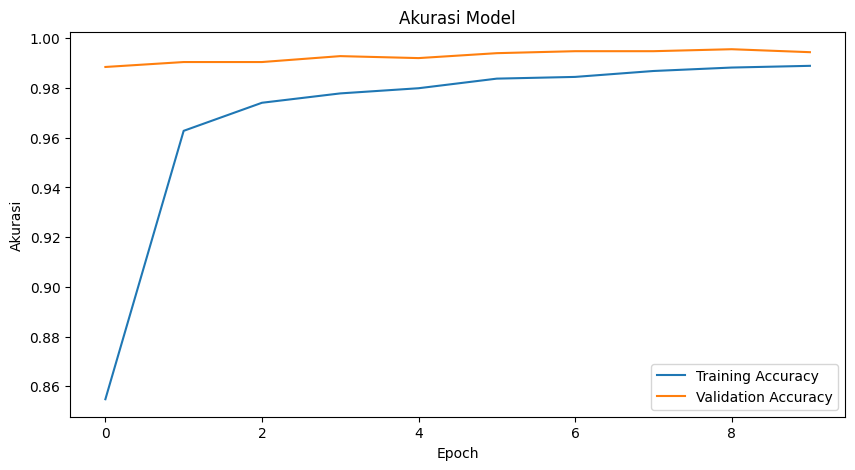

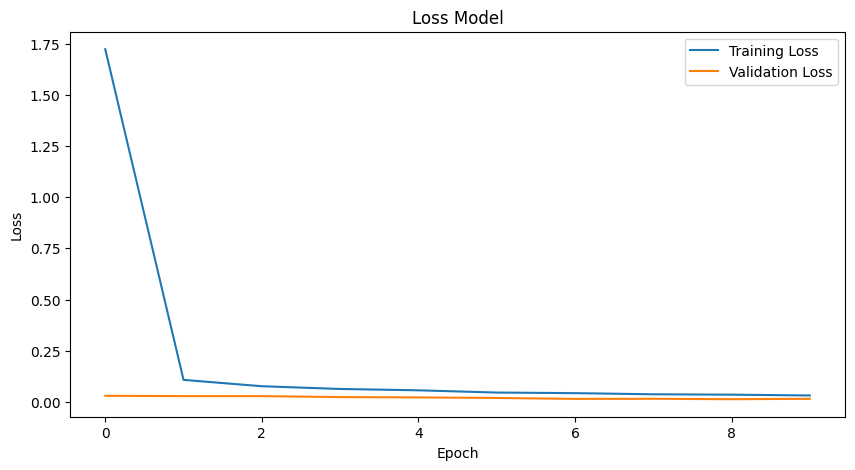

In [ ]:
# Plot Akurasi after fine tuning
plt.figure(figsize=(10, 5))
plt.plot(history_fine_tuning.history['accuracy'], label='Training Accuracy')
plt.plot(history_fine_tuning.history['val_accuracy'], label='Validation Accuracy')
plt.title('Akurasi Model')
plt.ylabel('Akurasi')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(history_fine_tuning.history['loss'], label='Training Loss')
plt.plot(history_fine_tuning.history['val_loss'], label='Validation Loss')
plt.title('Loss Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step


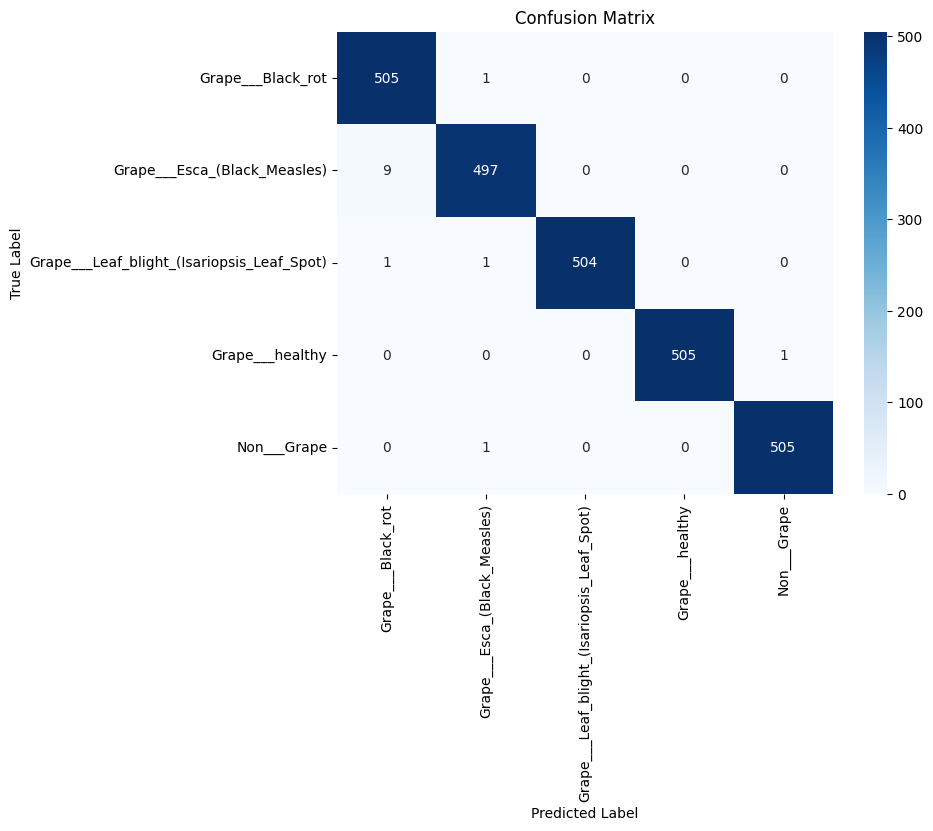

In [ ]:
from sklearn.metrics import confusion_matrix

# Prediksi pada data test
test_predictions = model.predict(test_generator, verbose=1)
test_predictions = np.argmax(test_predictions, axis=1)  # Get predicted class labels

# Dapatkan true labels dari test generator
true_labels = test_generator.classes

# Buat confusion matrix setelah fine tuning
cm = confusion_matrix(true_labels, test_predictions)

# Visualisasi confusion matrix menggunakan seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Test Image With Data Testing

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


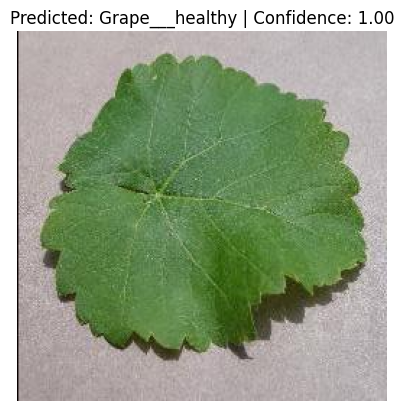

In [ ]:
# Fungsi untuk prediksi gambar
def predict_image(img_path, model, img_size):
    img = image.load_img(img_path, target_size=(img_size, img_size))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Menambah dimensi untuk batch size
    img_array /= 255.0  # Normalisasi
    prediction = model.predict(img_array)
    pred_class = np.argmax(prediction)  # Kelas yang diprediksi
    confidence = prediction[0][pred_class]  # Kepercayaan model terhadap prediksi
    return pred_class, confidence

# Fungsi untuk menampilkan gambar dan hasil prediksi
def display_image_and_prediction(img_path, pred_class, confidence, class_names):
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted: {class_names[pred_class]} | Confidence: {confidence:.2f}')
    plt.show()

# Coba prediksi gambar tertentu
img_path = '/content/Final_data/test/Grape___healthy/0ca59865-f0d2-4863-b4d1-a6690de53a5a___Mt.N.V_HL 6025_270deg.JPG'
pred_class, confidence = predict_image(img_path, model, img_size)

# Daftar nama kelas yang ada pada model
class_names = list(test_generator.class_indices.keys())

# Tampilkan gambar dan hasil prediksi
display_image_and_prediction(img_path, pred_class, confidence, class_names)


## Test With New Image Out Of Dataset

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


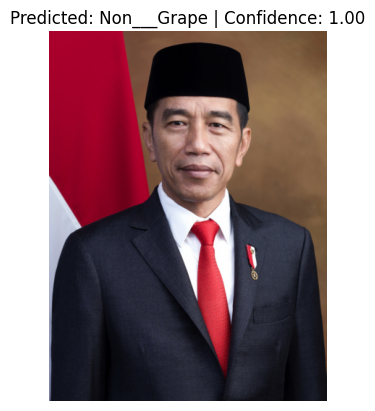

In [ ]:
# Fungsi untuk prediksi gambar
def predict_image(img_path, model, img_size):
    img = image.load_img(img_path, target_size=(img_size, img_size))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Menambah dimensi untuk batch size
    img_array /= 255.0  # Normalisasi
    prediction = model.predict(img_array)
    pred_class = np.argmax(prediction)  # Kelas yang diprediksi
    confidence = prediction[0][pred_class]  # Kepercayaan model terhadap prediksi
    return pred_class, confidence

# Fungsi untuk menampilkan gambar dan hasil prediksi
def display_image_and_prediction(img_path, pred_class, confidence, class_names):
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted: {class_names[pred_class]} | Confidence: {confidence:.2f}')
    plt.show()

# Coba prediksi gambar tertentu
img_path = '/content/presidenri.go.id-05022020111245-5e3a40bd7cdcb1.35250820-384x512.jpg'
pred_class, confidence = predict_image(img_path, model, img_size)

# Daftar nama kelas yang ada pada model
class_names = list(test_generator.class_indices.keys())

# Tampilkan gambar dan hasil prediksi
display_image_and_prediction(img_path, pred_class, confidence, class_names)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


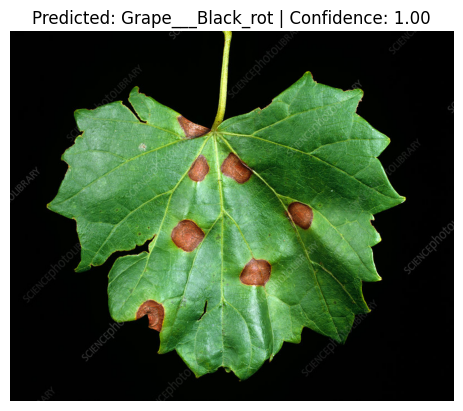

In [ ]:
# Fungsi untuk prediksi gambar
def predict_image(img_path, model, img_size):
    img = image.load_img(img_path, target_size=(img_size, img_size))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Menambah dimensi untuk batch size
    img_array /= 255.0  # Normalisasi
    prediction = model.predict(img_array)
    pred_class = np.argmax(prediction)  # Kelas yang diprediksi
    confidence = prediction[0][pred_class]  # Kepercayaan model terhadap prediksi
    return pred_class, confidence

# Fungsi untuk menampilkan gambar dan hasil prediksi
def display_image_and_prediction(img_path, pred_class, confidence, class_names):
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted: {class_names[pred_class]} | Confidence: {confidence:.2f}')
    plt.show()

# Coba prediksi gambar tertentu
img_path = '/content/c0121047-800px-wm.jpg'
pred_class, confidence = predict_image(img_path, model, img_size)

# Daftar nama kelas yang ada pada model
class_names = list(test_generator.class_indices.keys())

# Tampilkan gambar dan hasil prediksi
display_image_and_prediction(img_path, pred_class, confidence, class_names)


# Saved Model

In [ ]:
# Save the fine-tuned model
model.save('Final Grape MobileNetV2 model.h5')